In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tools.rsa import compute_similarity
from models.admm import ADMM
from utils.helpers import median_matrix_split, best_pairwise_match, zero_matrix_split
from utils.plotting import plot_images_from_embedding
import seaborn as sns
import pandas as pd
from pathlib import Path


df_simulation_raw = pd.read_csv("../results/cross_validation/rank_experiment_simulation_raw_test.csv")

/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


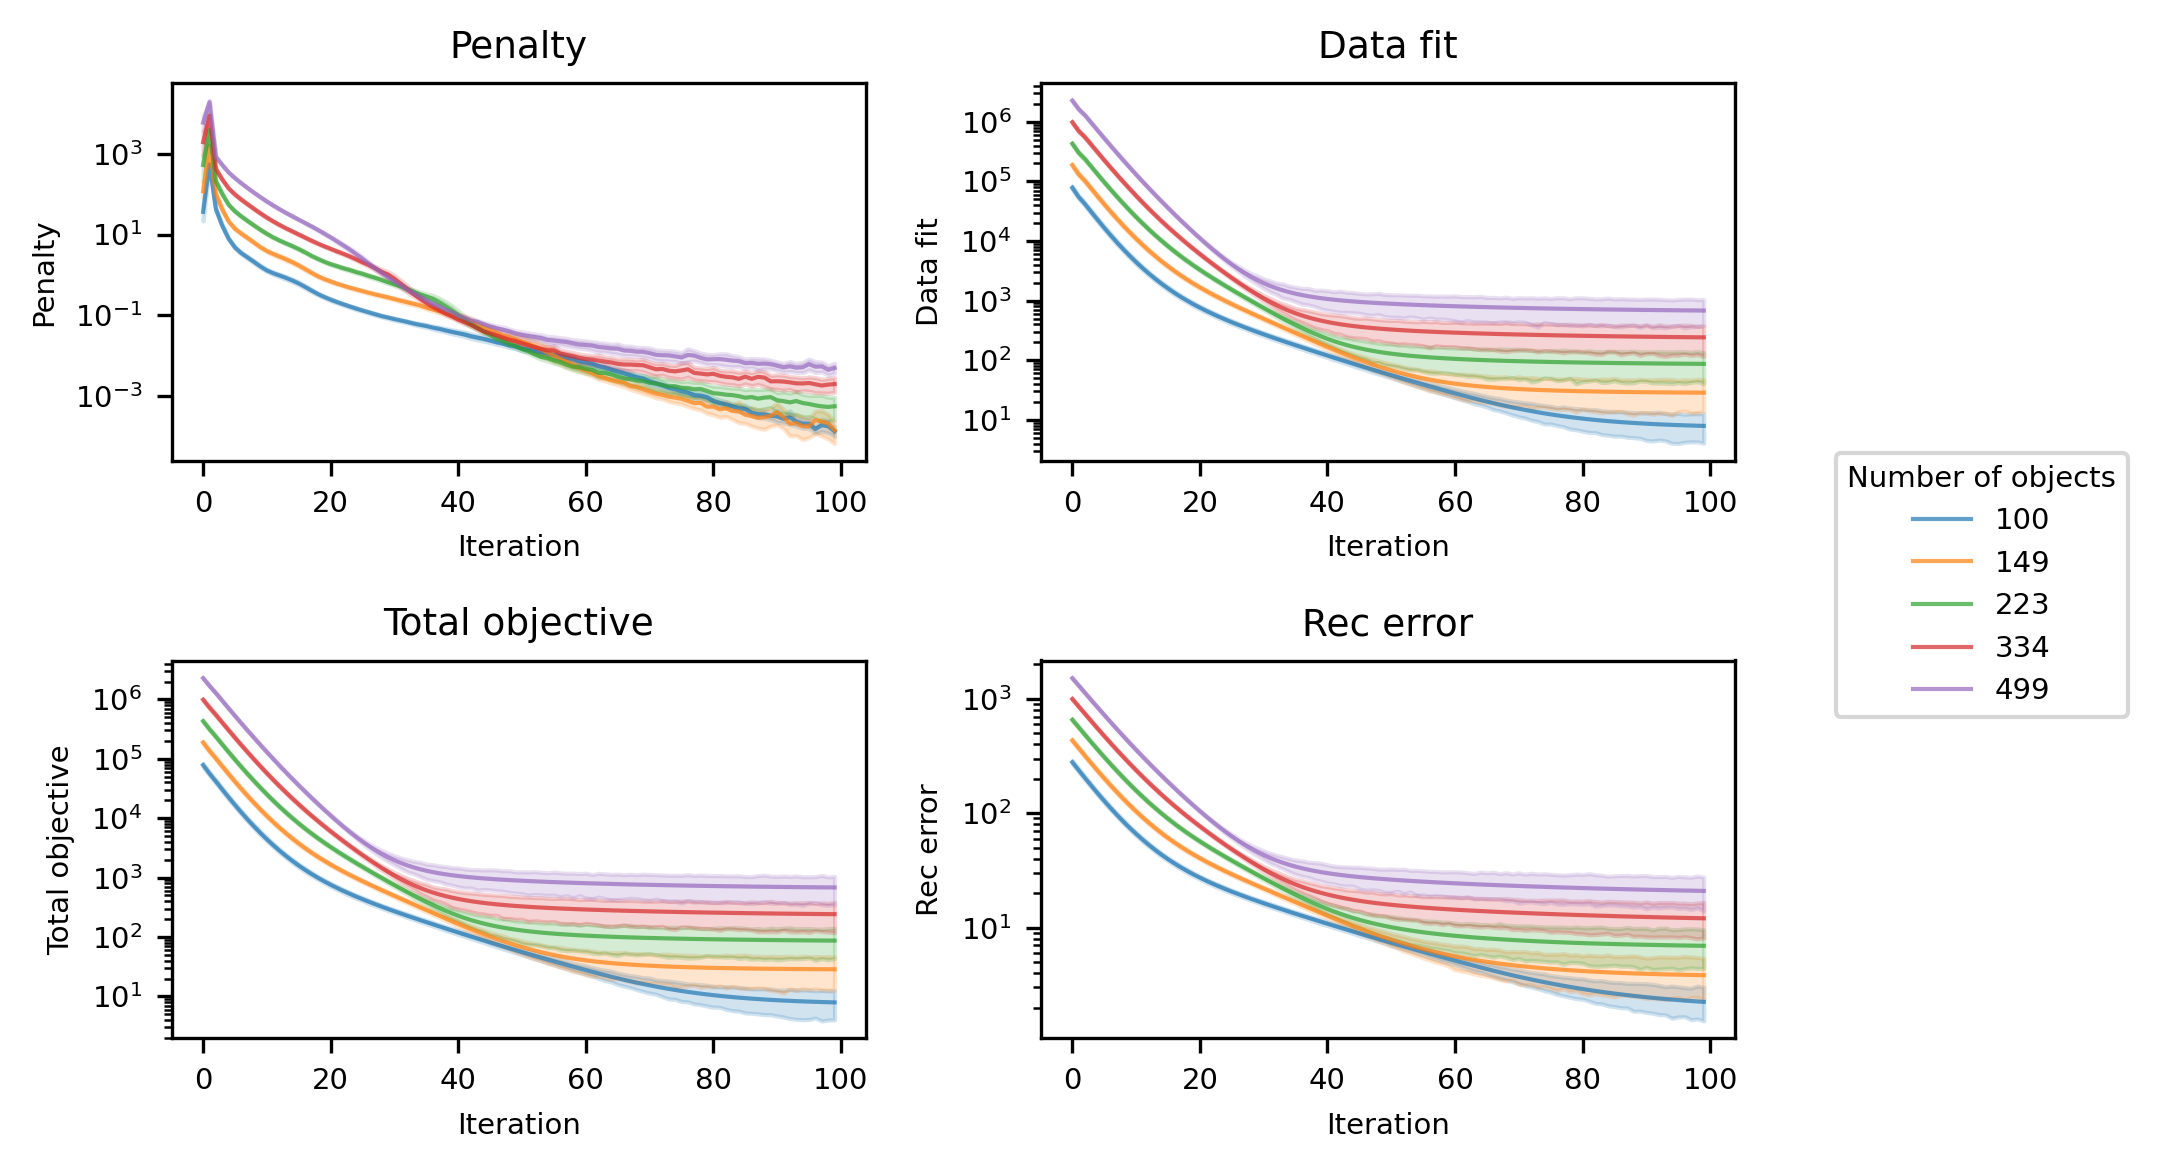

In [50]:
df = pd.read_csv("../results/cross_validation/parameter_convergence_histories.csv")

metrics = ["penalty", "data_fit", "total_objective", "rec_error"]

fig, axes = plt.subplots(2, 2, figsize=(6, 4), dpi=300)

unique_n_objects = sorted(df["n_objects"].unique())
hue_labels = [str(n) for n in unique_n_objects]

for ax, metric in zip(axes.flat, metrics):
    sns.lineplot(
        data=df,
        x="iteration",
        y=metric,
        hue="n_objects",
        alpha=0.7,
        linewidth=1.0,
        legend=False,
        palette="tab10",
        ax=ax,
    )
    ax.set_title(metric.replace("_", " ").capitalize(), fontsize=9)
    ax.set_xlabel("Iteration", fontsize=7)
    ax.set_ylabel(metric.replace("_", " ").capitalize(), fontsize=7)
    ax.set_yscale("log")
    ax.tick_params(labelsize=7)

lines = []
for n in unique_n_objects:
    (line,) = axes[0, 0].plot([], [], label=str(n))
    lines.append(line)

fig.legend(
    handles=axes[0, 0].get_lines()[: len(unique_n_objects)],
    labels=hue_labels,
    title="Number of objects",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    fontsize=7,
    title_fontsize=7,
)
plt.tight_layout()
plt.show()


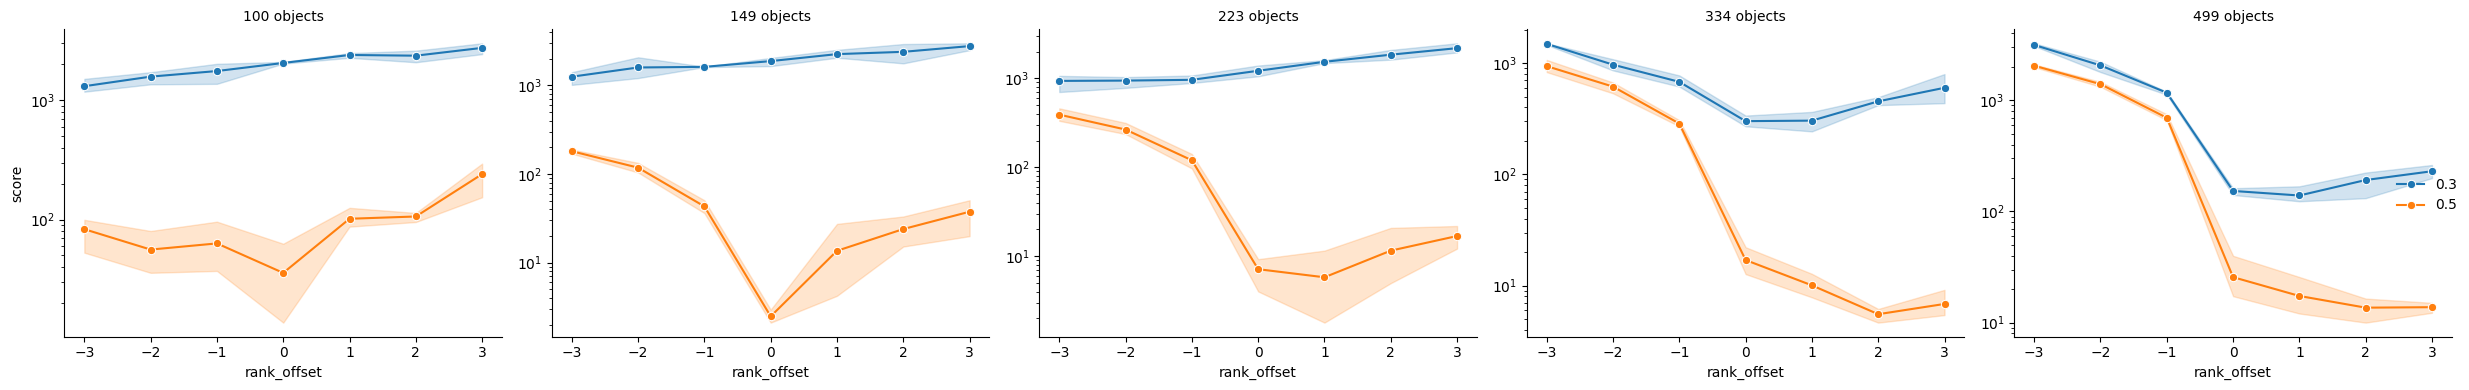

In [ ]:
df_simulation_raw = pd.read_csv(
    "../results/cross_validation/rank_experiment_simulation_raw_test.csv"
)

df = df_simulation_raw
df = df[df["rho"] == 3.0]
df = df[df["snr"] == 1.0]
df = df[df["true_rank"] == 10]
df = df[df["similarity_measure"] == "linear"]

df["rank_offset"] = df["rank"] - df["true_rank"]

g = sns.FacetGrid(df, col="n_objects", col_wrap=5, height=4, aspect=1.2, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="rank_offset",
    y="score",
    hue="observed_fraction",
    marker="o",
    palette="tab10",
)
g.set(yscale="log")
g.set_titles(col_template="{col_name} objects")
g.add_legend()
plt.tight_layout()


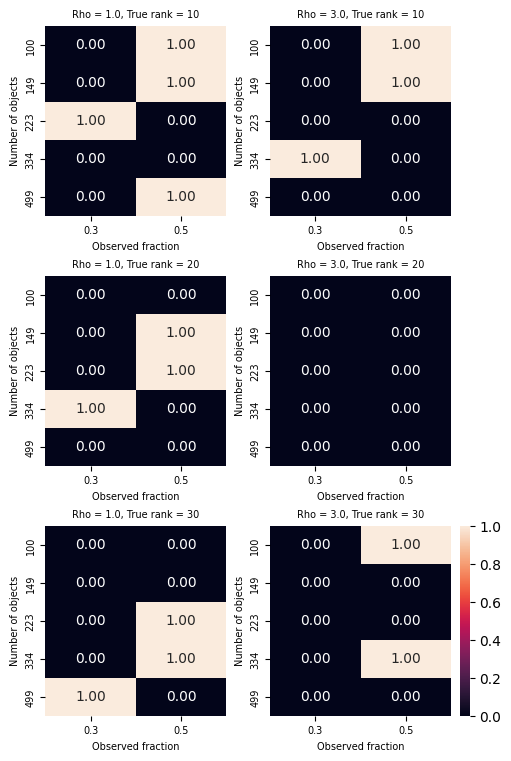

In [ ]:
df_simulation_summary = pd.read_csv(
    "../results/cross_validation/rank_experiment_simulation_test.csv"
)

unique_rhos = sorted(df_simulation_summary["rho"].unique())
unique_true_ranks = sorted(df_simulation_summary["true_rank"].unique())
n_rhos = len(unique_rhos)
n_true_ranks = len(unique_true_ranks)

fig, axes = plt.subplots(
    n_true_ranks,
    n_rhos,
    figsize=(2.5 * n_rhos, 2.5 * n_true_ranks),
    constrained_layout=True,
)

if n_true_ranks == 1 and n_rhos == 1:
    axes = np.array([[axes]])
elif n_true_ranks == 1:
    axes = axes[np.newaxis, :]
elif n_rhos == 1:
    axes = axes[:, np.newaxis]

for i, true_rank in enumerate(unique_true_ranks):
    for j, rho in enumerate(unique_rhos):
        df_sub = df_simulation_summary[
            (df_simulation_summary["rho"] == rho)
            & (df_simulation_summary["true_rank"] == true_rank)
        ]
        success_fraction = (
            df_sub.groupby(["n_objects", "observed_fraction"])["rank_correct"]
            .mean()
            .unstack()
        )
        ax = axes[i, j]
        sns.heatmap(
            success_fraction,
            annot=True,
            fmt=".2f",
            ax=ax,
            cbar=(i == n_true_ranks - 1 and j == n_rhos - 1),
        )
        ax.set_title(f"Rho = {rho}, True rank = {true_rank}", fontsize=7)
        ax.set_xlabel("Observed fraction", fontsize=7)
        ax.set_ylabel("Number of objects", fontsize=7)
        ax.tick_params(labelsize=7)

plt.show()


In [ ]:
condition_cols = [
    "n_objects",
    "true_rank",
    "observed_fraction",
    "snr",
    "rho",
    "max_outer",
    "max_inner",
]

final_results = []
for condition_values, group in df_simulation_raw.groupby(condition_cols):
    condition_dict = dict(zip(condition_cols, condition_values))

    # Compute mean score for each rank across trials
    rank_scores = group.groupby("rank")["score"].mean()
    best_rank = rank_scores.idxmin()
    best_score = rank_scores.min()

    final_results.append(
        {
            **condition_dict,
            "best_rank": int(best_rank),
            "best_score": best_score,
            "rank_correct": best_rank == condition_dict["true_rank"],
            "rank_error": abs(best_rank - condition_dict["true_rank"]),
            "similarity_measure": "linear",
        }
    )

df_simulation = pd.DataFrame(final_results)


In [2]:
df_accuracy = (
    df_simulation_raw.groupby(
        [
            "n_objects",
            "true_rank",
            "observed_fraction",
            "snr",
            "rho",
            "max_outer",
            "max_inner",
            "rank",
            "similarity_measure",
        ]
    )["score"]
    .mean()
    .reset_index()
)


In [ ]:
df_simulation_raw


n_objects  true_rank  observed_fraction  snr  rho  max_outer  max_inner  \
0          100         20                0.8  1.0  3.0         20         20   
1          100         20                0.8  1.0  3.0         20         20   
2          100         20                0.8  1.0  3.0         20         20   
3          100         20                0.8  1.0  3.0         20         20   
4          100         20                0.8  1.0  3.0         20         20   
..         ...        ...                ...  ...  ...        ...        ...   
100       1000         20                0.8  1.0  3.0         20         20   
101       1000         20                0.8  1.0  3.0         20         20   
102       1000         20                0.8  1.0  3.0         20         20   
103       1000         20                0.8  1.0  3.0         20         20   
104       1000         20                0.8  1.0  3.0         20         20   

     trial_id  rank     score  seed similarity_measure  
0           0    17  0.033812     0             linear  
1           0    18  0.078621     1             linear  
2           0    19  0.060915     2             linear  
3           0    20  0.103917     3             linear  
4           0    21  0.048433     4             linear  
..        ...   ...       ...   ...                ...  
100         2    19  0.004833   100             linear  
101         2    20  0.000992   101             linear  
102         2    21  0.000308   102             linear  
103         2    22  0.000354   103             linear  
104         2    23  0.000291   104             linear  

[105 rows x 12 columns]

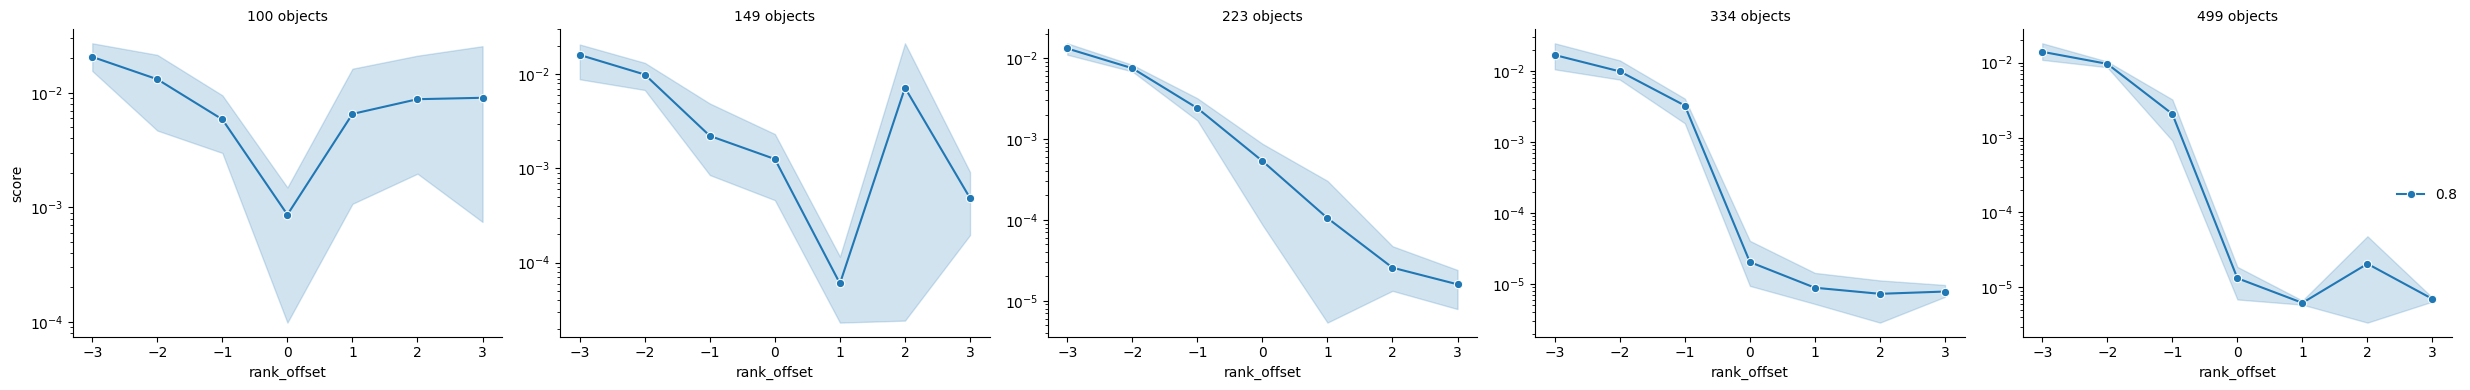

In [38]:
df_simulation_raw = pd.read_csv(
    "../results/cross_validation/rank_experiment_simulation_raw_test.csv"
)

df = df_simulation_raw
df = df[df["rho"] == 3.0]
df = df[df["snr"] == 1.0]
# df = df[df["true_rank"] == 10]
df = df[df["similarity_measure"] == "linear"]

df["rank_offset"] = df["rank"] - df["true_rank"]

g = sns.FacetGrid(df, col="n_objects", col_wrap=5, height=4, aspect=1.2, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="rank_offset",
    y="score",
    hue="observed_fraction",
    marker="o",
    palette="tab10",
)
g.set(yscale="log")
g.set_titles(col_template="{col_name} objects")
g.add_legend()
plt.tight_layout()


In [ ]:
df_simulation_raw = pd.read_csv(
    "../results/cross_validation/rank_experiment_simulation_raw_test.csv"
)

df = df_simulation_raw
df = df[df["rho"] == 1.0]
df = df[df["snr"] == 1.0]
df = df[df["true_rank"] == 20]
df = df[df["similarity_measure"] == "linear"]

df["rank_offset"] = df["rank"] - df["true_rank"]

g = sns.FacetGrid(df, col="n_objects", col_wrap=5, height=4, aspect=1.2, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="rank_offset",
    y="score",
    hue="observed_fraction",
    marker="o",
    palette="tab10",
)
g.set(yscale="log")
g.set_titles(col_template="{col_name} objects")
g.add_legend()
plt.tight_layout()


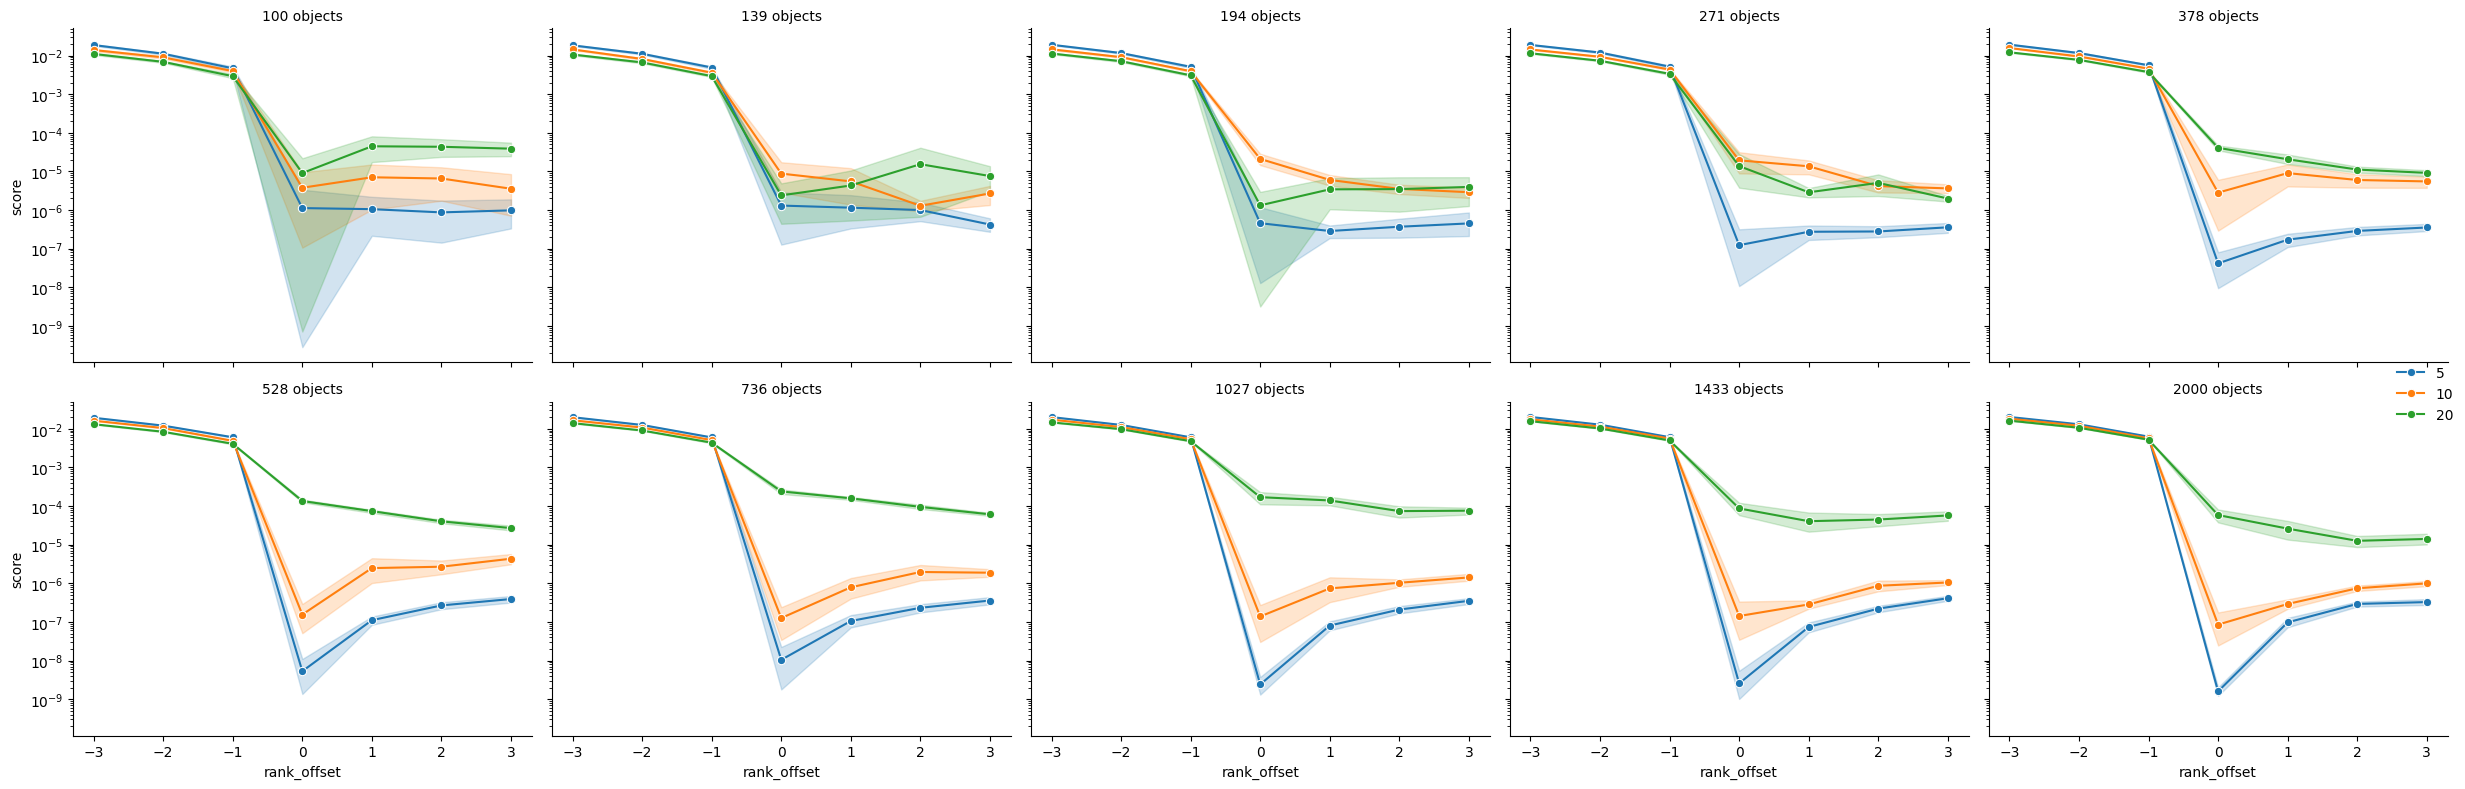

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_simulation_raw

df = df[df["rho"] == 1.0]
df = df[df["snr"] == 1.0]
df = df[df["observed_fraction"] == 0.7]
df = df[df["similarity_measure"] == "linear"]

df["rank_offset"] = df["rank"] - df["true_rank"]

g = sns.FacetGrid(df, col="n_objects", col_wrap=5, height=4, aspect=1.2)
g.map_dataframe(
    sns.lineplot,
    x="rank_offset",
    y="score",
    hue="true_rank",
    marker="o",
    palette="tab10",
)
g.set(yscale="log")
g.set_titles(col_template="{col_name} objects")
g.add_legend()
plt.tight_layout()


### Below we check if there is a power law or somethig similar between the nuber of objects and the optimal training ratio

<Figure size 960x720 with 0 Axes>

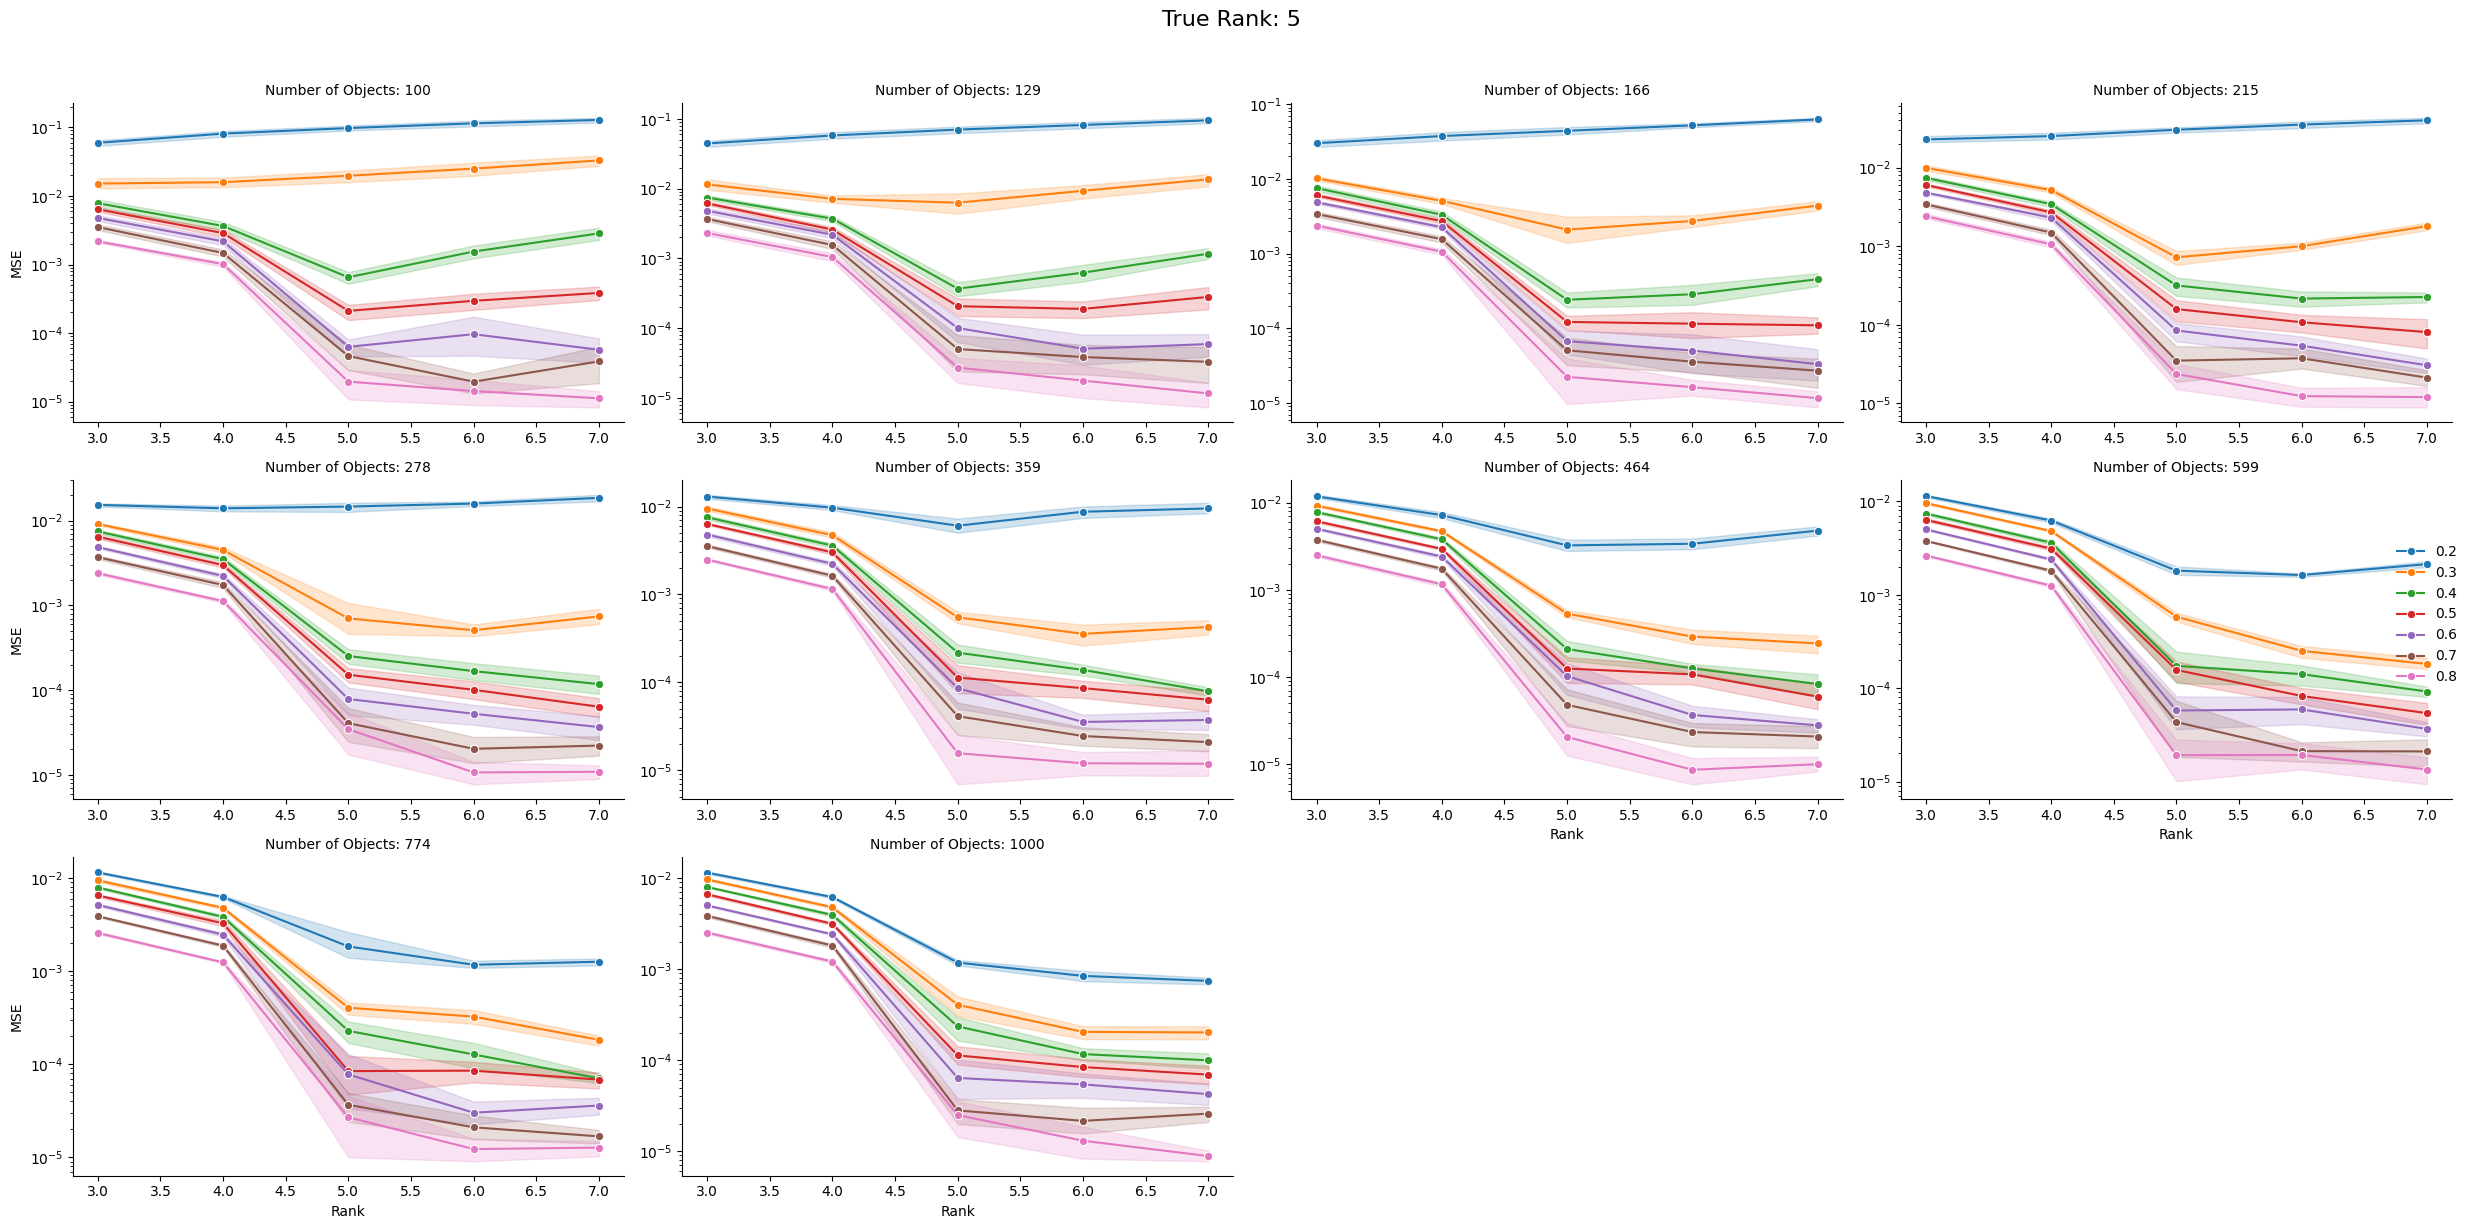

<Figure size 960x720 with 0 Axes>

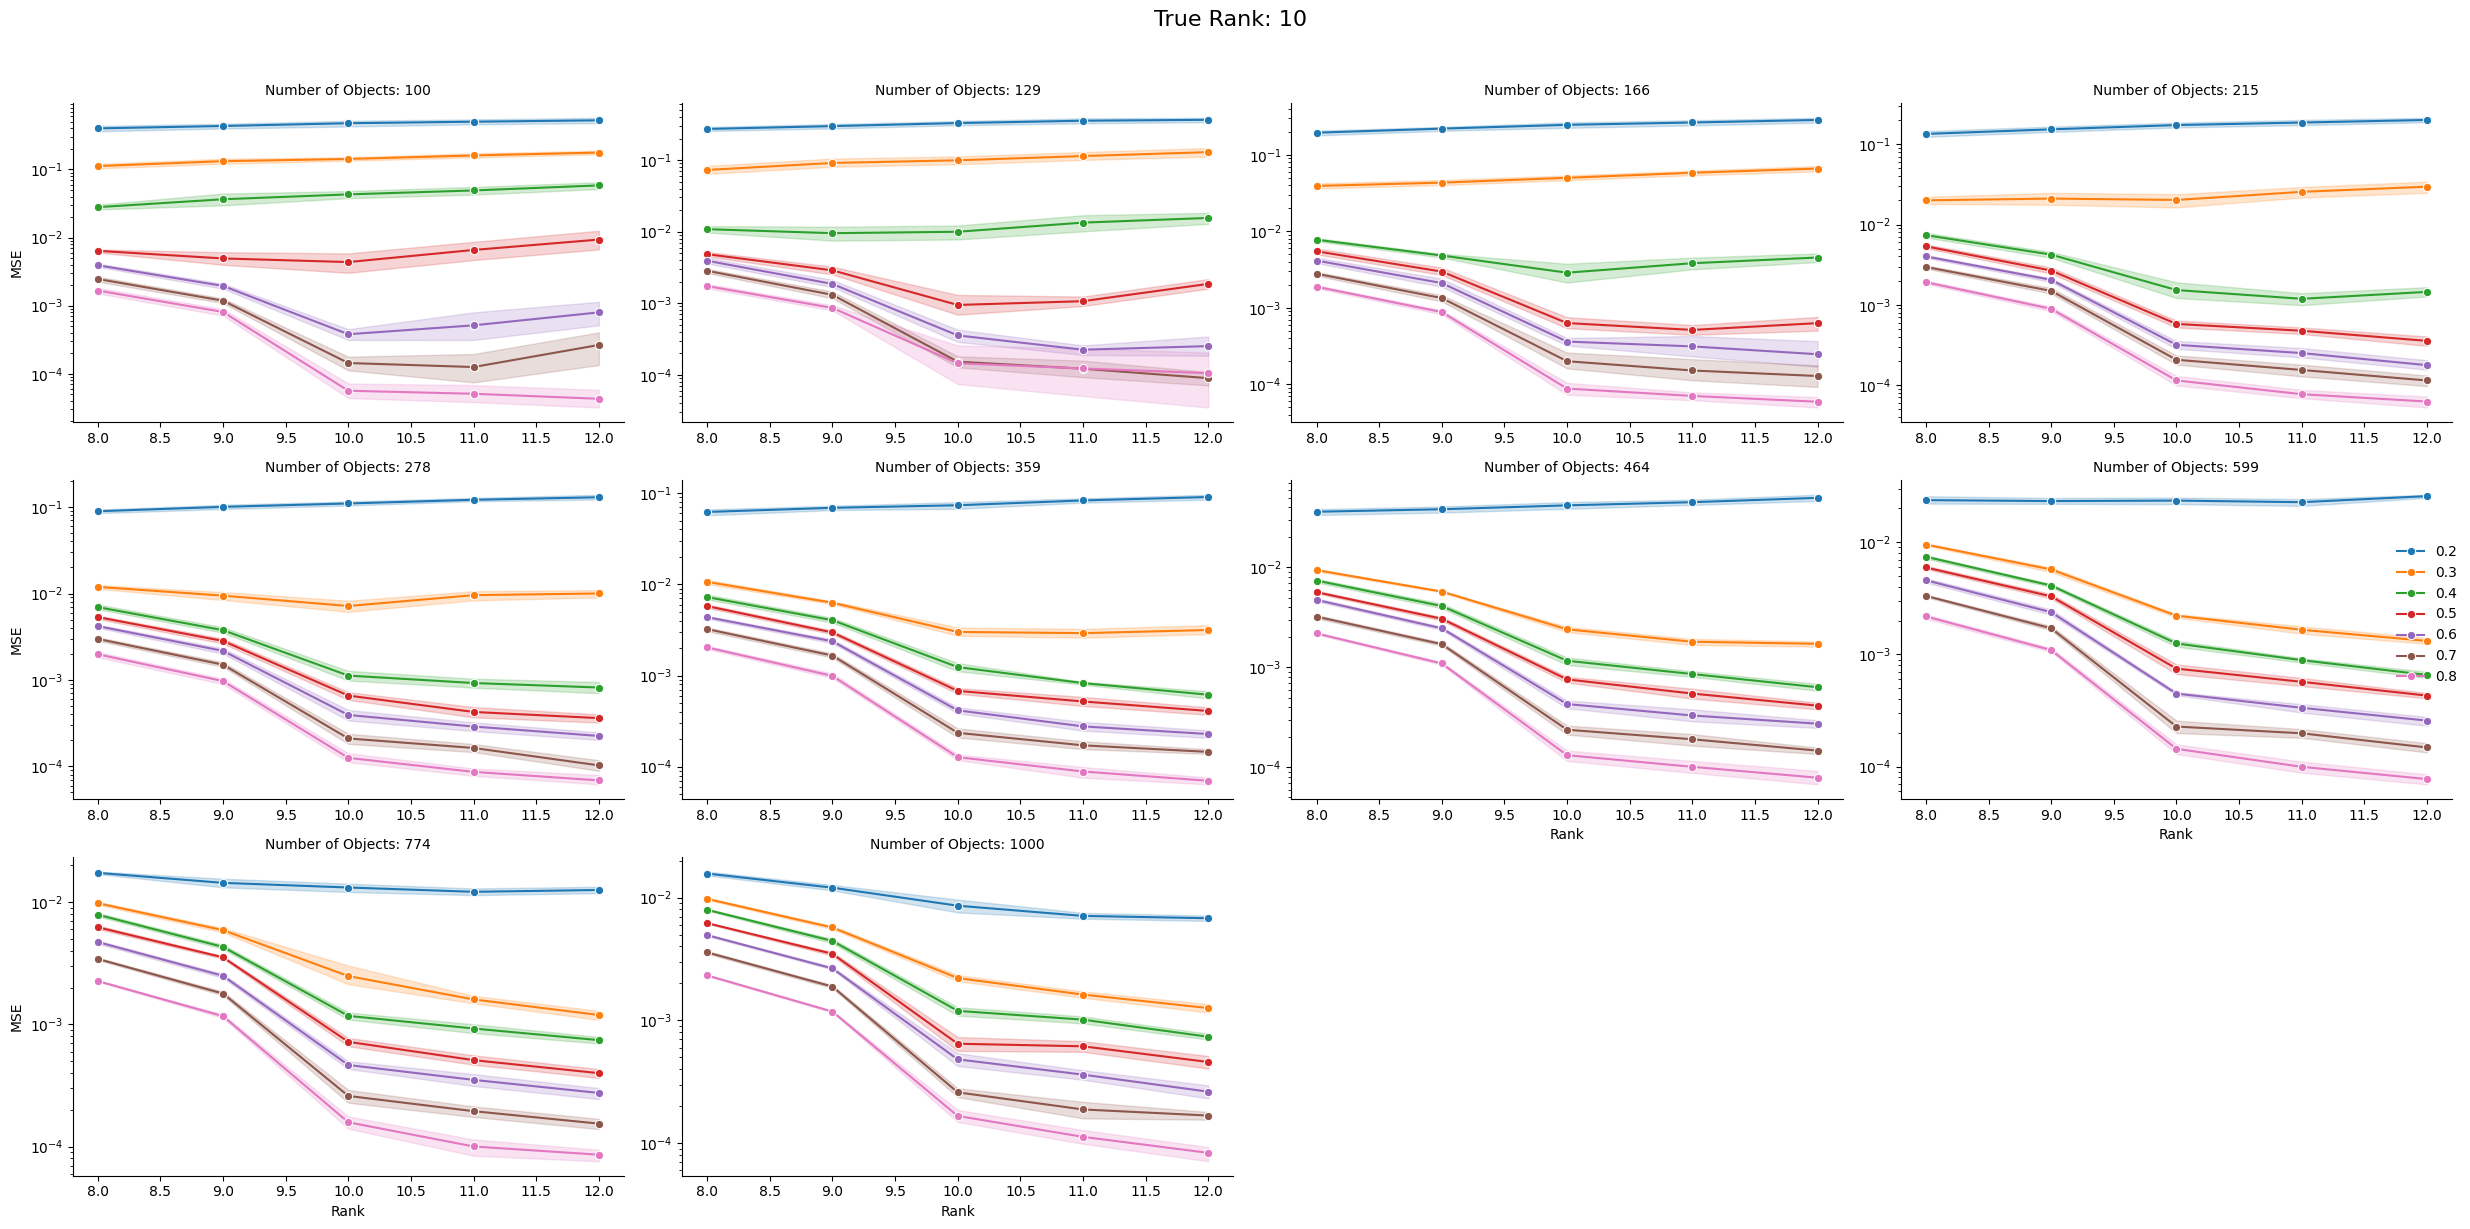

<Figure size 960x720 with 0 Axes>

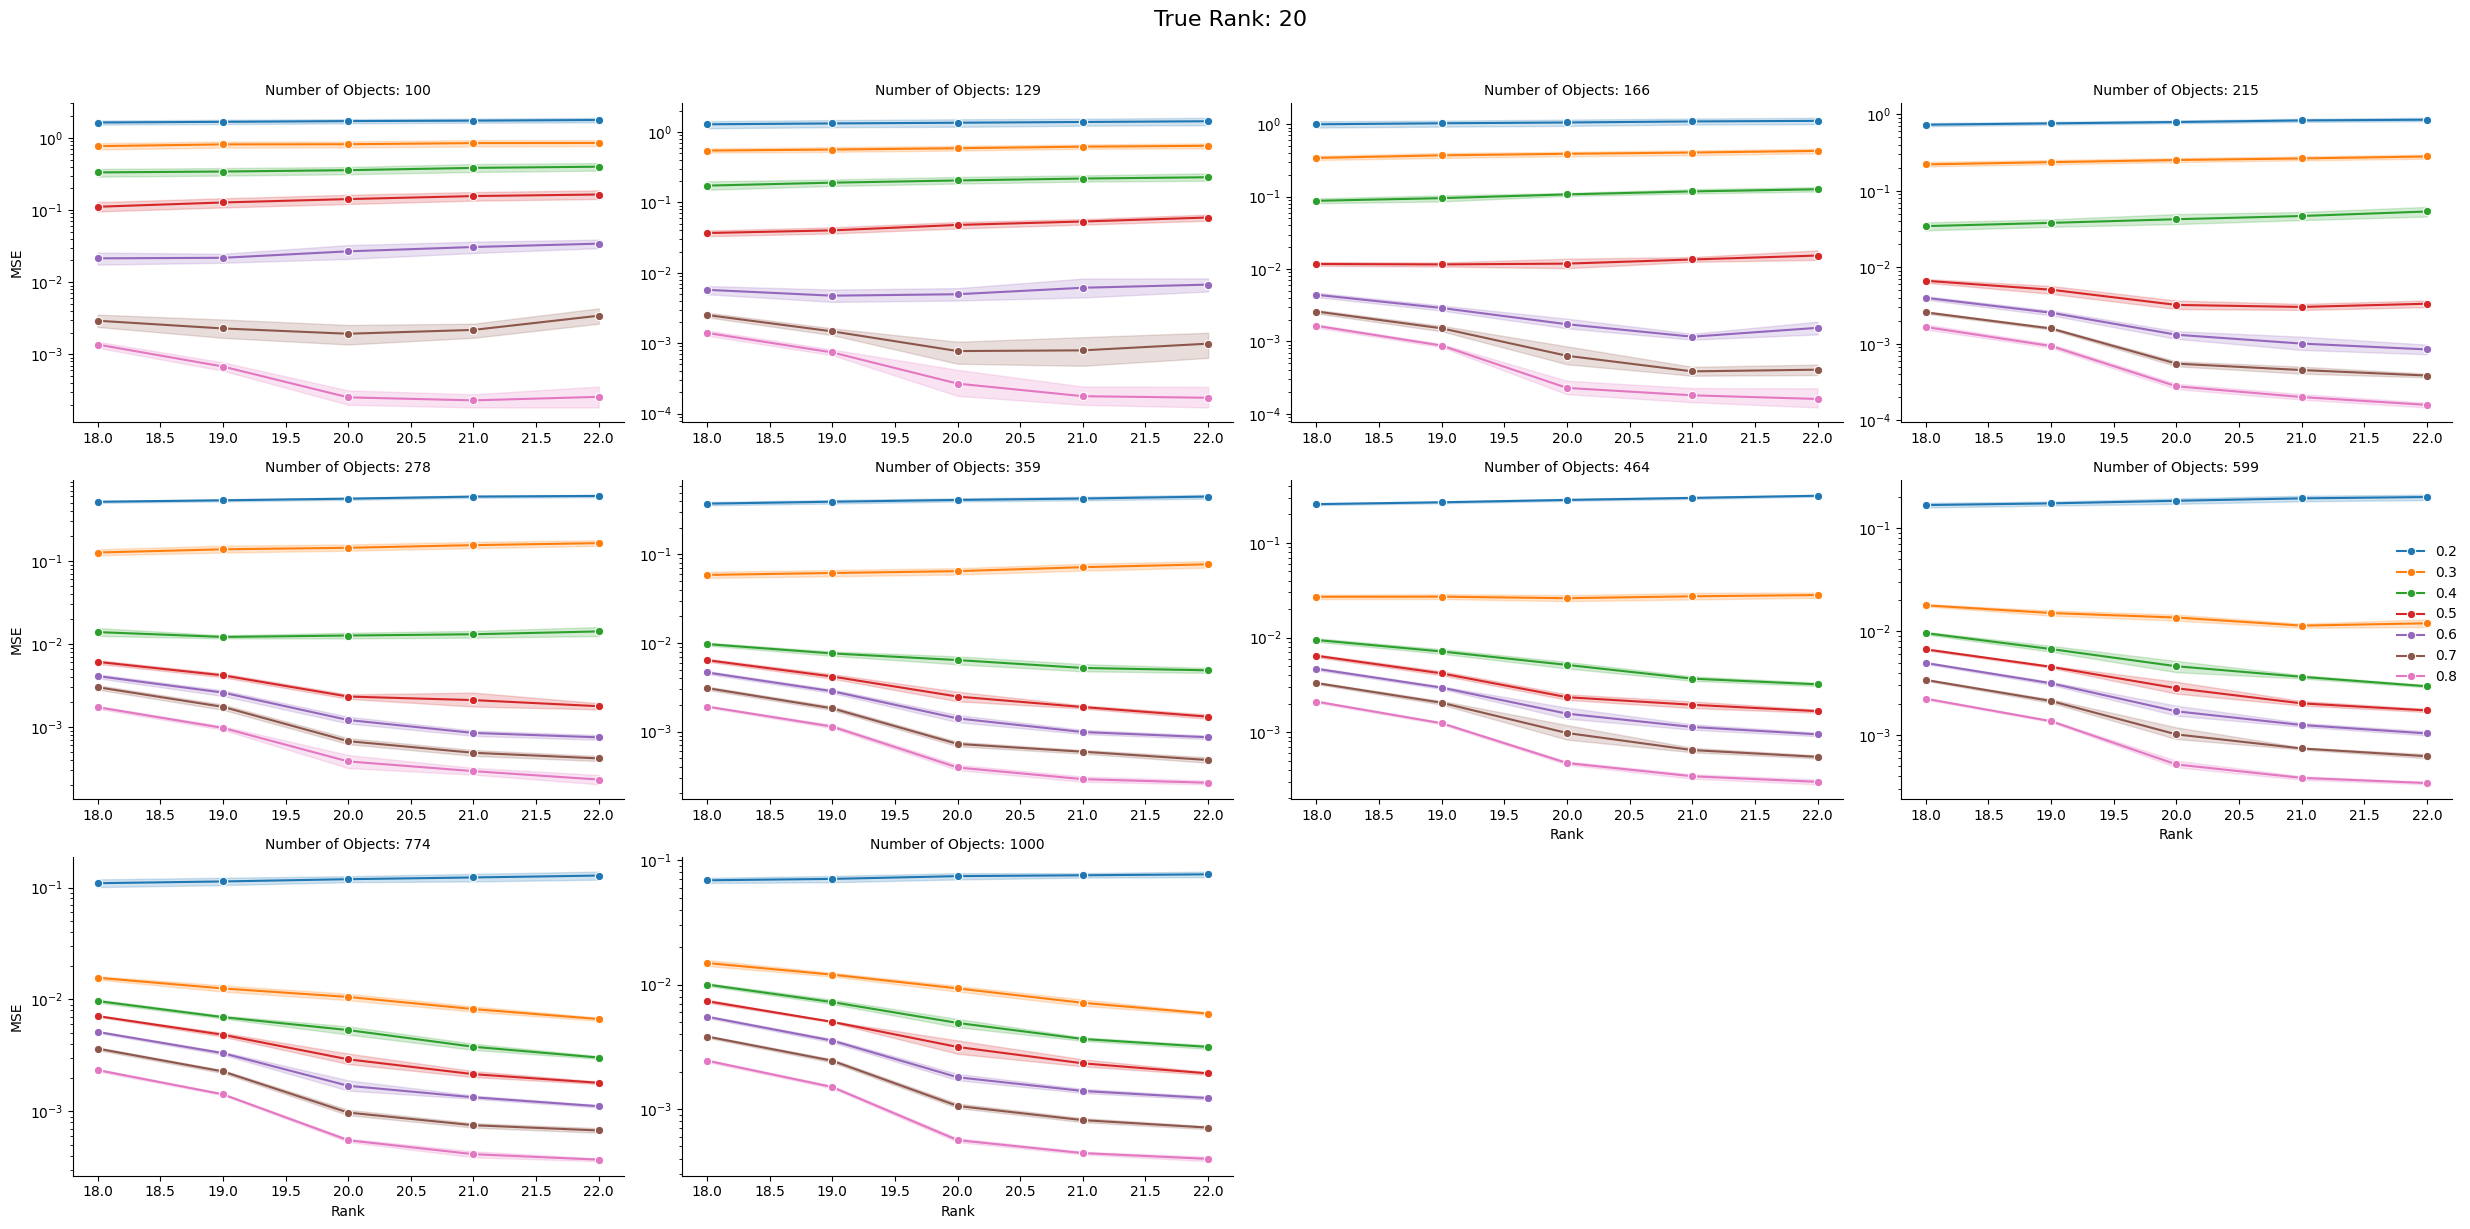

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_similarity[df_similarity["snr"] == 1.0]

unique_true_ranks = sorted(df["true_rank"].unique())

for true_rank in unique_true_ranks:
    df_subset = df[df["true_rank"] == true_rank]

    plt.figure(dpi=150)
    g = sns.FacetGrid(
        df_subset,
        col="n_objects",
        col_wrap=4,
        height=4,
        aspect=1.5,
        sharey=False,
        sharex=False,
    )
    g.map_dataframe(
        sns.lineplot,
        x="rank",
        y="mse",
        hue="observed_fraction",
        marker="o",
        palette="tab10",
    )
    g.add_legend()
    g.set_axis_labels("Rank", "MSE")
    g.set_titles("Number of Objects: {col_name}")

    for ax in g.axes.flat:
        ax.set_yscale("log")

    plt.suptitle(f"True Rank: {true_rank}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


In [119]:
df_simulation


n_objects  true_rank  observed_fraction  snr  rho  max_outer  max_inner  \
0           100          5                0.8  0.5  1.0         10         50   
1           100          5                0.8  0.5  1.0         10         50   
2           100          5                0.8  0.5  1.0         10         50   
3           100          5                0.8  0.5  1.0         10         50   
4           100          5                0.8  0.5  1.0         10         50   
...         ...        ...                ...  ...  ...        ...        ...   
9595       1000         20                0.8  1.0  2.0         50         50   
9596       1000         20                0.8  1.0  2.0         50         50   
9597       1000         20                0.8  1.0  2.0         50         50   
9598       1000         20                0.8  1.0  2.0         50         50   
9599       1000         20                0.8  1.0  2.0         50         50   

      trial_id  best_rank  best_score  rank_correct  rank_error  seed  \
0            0          7    0.000879         False           2     0   
1            1          6    0.001466         False           1     1   
2            2          7    0.001118         False           2     2   
3            3          7    0.000558         False           2     3   
4            4          7    0.000772         False           2     4   
...        ...        ...         ...           ...         ...   ...   
9595        15         22    0.000585         False           2  9595   
9596        16         22    0.000397         False           2  9596   
9597        17         22    0.000475         False           2  9597   
9598        18         22    0.000570         False           2  9598   
9599        19         22    0.000497         False           2  9599   

     similarity_measure  
0                linear  
1                linear  
2                linear  
3                linear  
4                linear  
...                 ...  
9595             linear  
9596             linear  
9597             linear  
9598             linear  
9599             linear  

[9600 rows x 14 columns]

KeyError: 'Column not found: score'

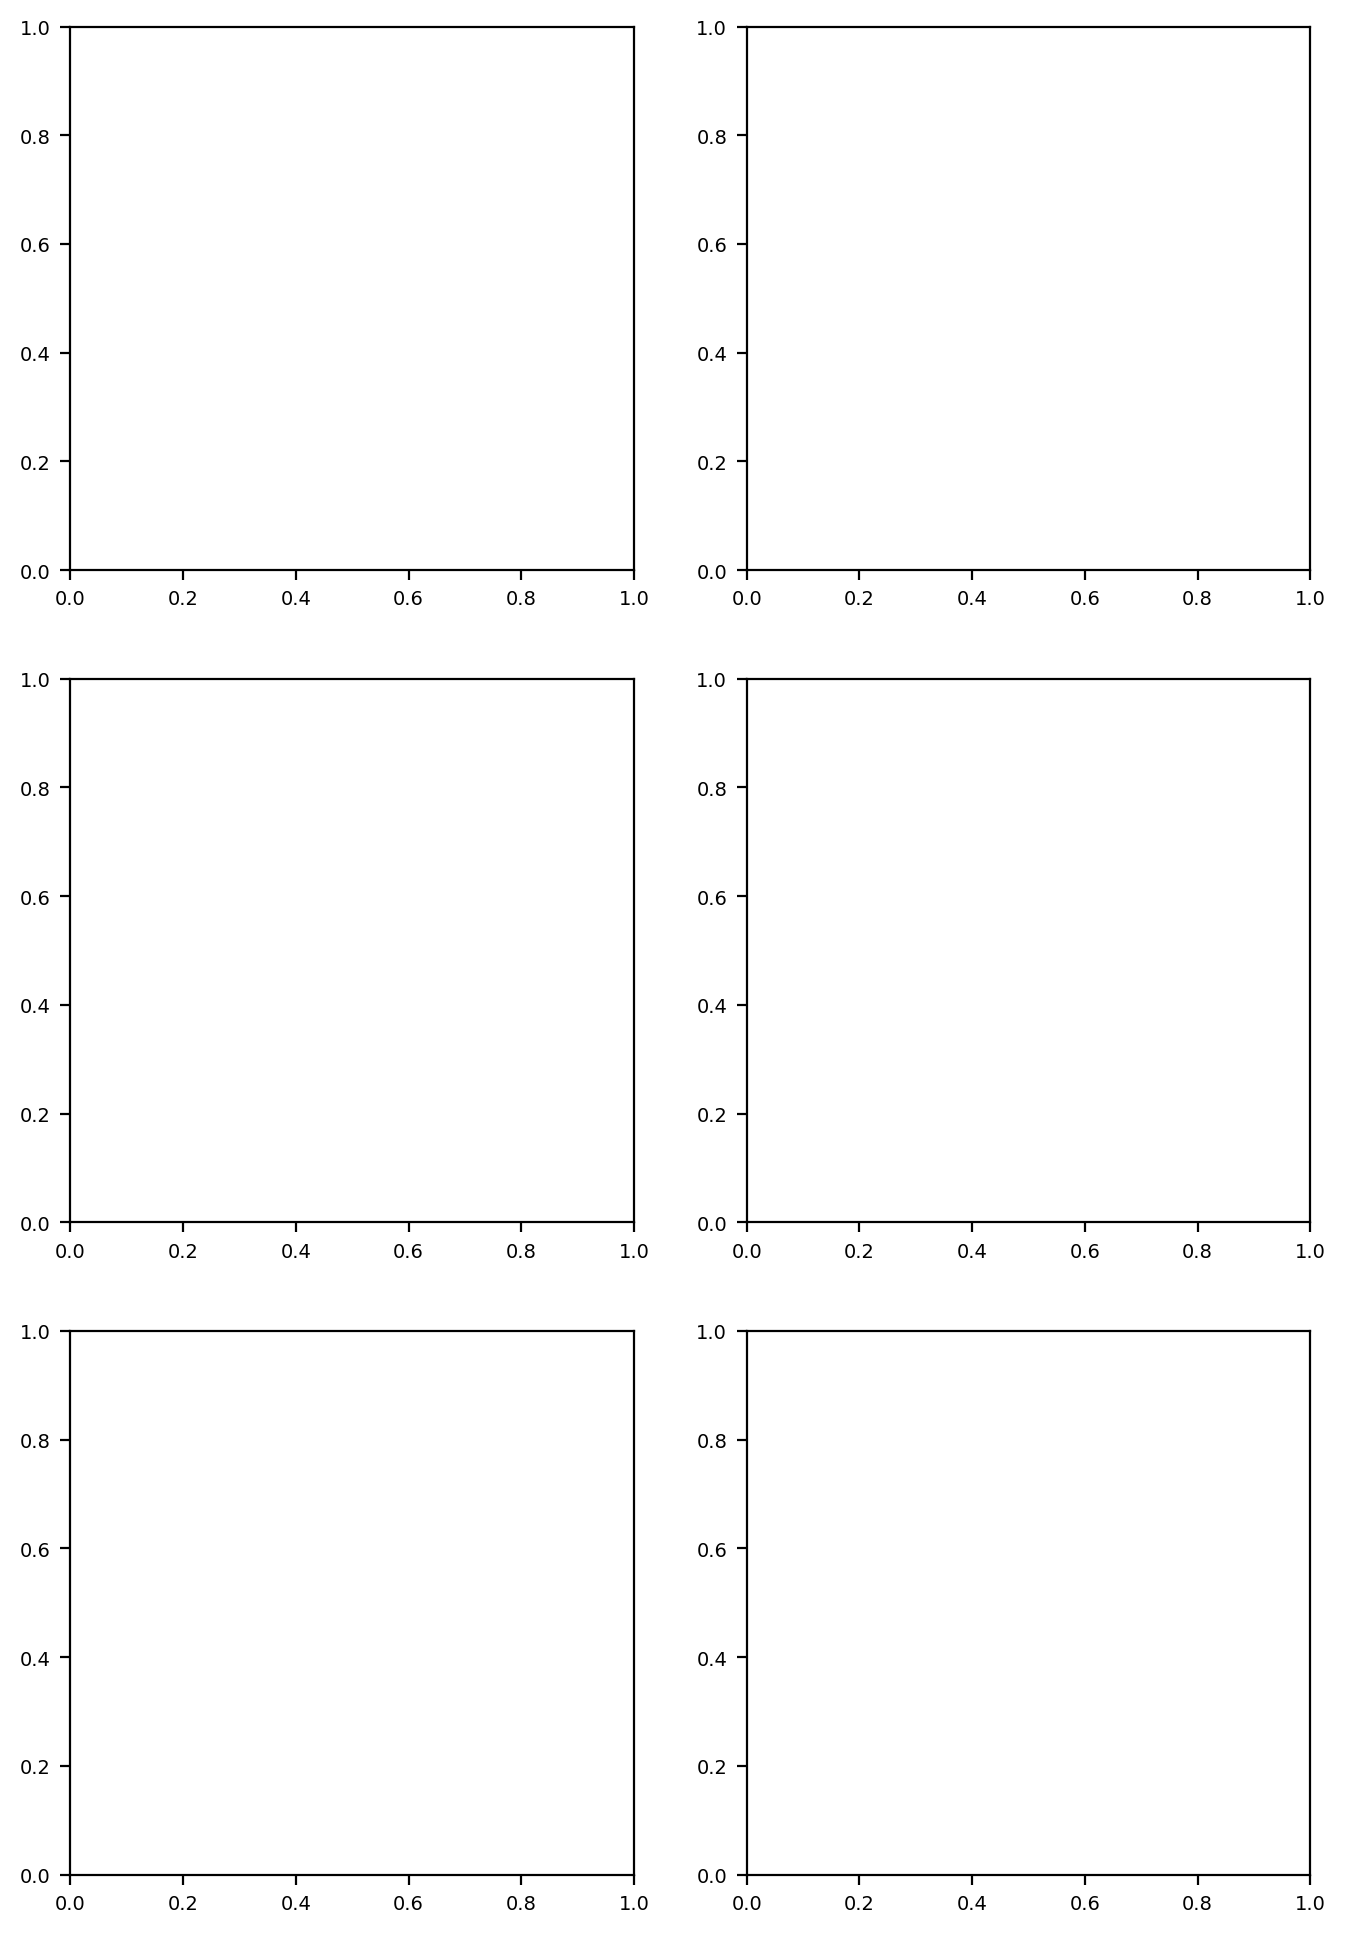

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_optimal_ratios(df_subset, true_rank, snr):
    best_ranks = df_subset.groupby(["n_objects", "observed_fraction", "trial_id"])[
        "score"
    ].idxmin()
    best_ranks_df = df_subset.loc[best_ranks]

    best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]
    accuracy_df = (
        best_ranks_df.groupby(["n_objects", "observed_fraction"])["correct_rank"]
        .mean()
        .reset_index()
    )

    optimal_ratios = []
    object_counts = []

    for n_obj in sorted(df_subset["n_objects"].unique()):
        subset = accuracy_df[accuracy_df["n_objects"] == n_obj]
        best_ratio = subset.loc[subset["correct_rank"].idxmax(), "observed_fraction"]
        optimal_ratios.append(best_ratio)
        object_counts.append(n_obj)

    plt.plot(
        object_counts,
        np.array(optimal_ratios) * 100,
        "o-",
        linewidth=2,
        markersize=8,
        color="red",
    )

    z = np.polyfit(np.log10(object_counts), np.array(optimal_ratios) * 100, 1)
    p = np.poly1d(z)
    plt.plot(
        object_counts,
        p(np.log10(object_counts)),
        "--",
        alpha=0.8,
        color="blue",
        label=f"Log fit: slope={z[0]:.4f}",
    )

    plt.xlabel("Total Number of Objects")
    plt.ylabel("Similarities Included (%)")
    plt.title(f"True Rank: {true_rank}, SNR: {snr}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xscale("log")


df = df_simulation
unique_true_ranks = sorted(df["true_rank"].unique())
unique_snrs = sorted(df["snr"].unique())

fig, axes = plt.subplots(
    len(unique_true_ranks),
    len(unique_snrs),
    figsize=(4 * len(unique_snrs), 4 * len(unique_true_ranks)),
    dpi=200,
)

for i, true_rank in enumerate(unique_true_ranks):
    for j, snr in enumerate(unique_snrs):
        df_subset = df[(df["true_rank"] == true_rank) & (df["snr"] == snr)]

        if len(df_subset) > 0:
            ax = axes[i, j] if len(unique_true_ranks) > 1 else axes[j]
            plt.sca(ax)
            plot_optimal_ratios(df_subset, true_rank, snr)

plt.tight_layout()
plt.show()


In [50]:
df_simulation


n_objects  true_rank  observed_fraction  snr  rho  max_outer  max_inner  \
0           100          5                0.8  0.5  1.0         10         50   
1           100          5                0.8  0.5  1.0         10         50   
2           100          5                0.8  0.5  1.0         10         50   
3           100          5                0.8  0.5  1.0         10         50   
4           100          5                0.8  0.5  1.0         10         50   
...         ...        ...                ...  ...  ...        ...        ...   
9595       1000         20                0.8  1.0  2.0         50         50   
9596       1000         20                0.8  1.0  2.0         50         50   
9597       1000         20                0.8  1.0  2.0         50         50   
9598       1000         20                0.8  1.0  2.0         50         50   
9599       1000         20                0.8  1.0  2.0         50         50   

      trial_id  best_rank  best_score  rank_correct  rank_error  seed  \
0            0          7    0.000879         False           2     0   
1            1          6    0.001466         False           1     1   
2            2          7    0.001118         False           2     2   
3            3          7    0.000558         False           2     3   
4            4          7    0.000772         False           2     4   
...        ...        ...         ...           ...         ...   ...   
9595        15         22    0.000585         False           2  9595   
9596        16         22    0.000397         False           2  9596   
9597        17         22    0.000475         False           2  9597   
9598        18         22    0.000570         False           2  9598   
9599        19         22    0.000497         False           2  9599   

     similarity_measure  
0                linear  
1                linear  
2                linear  
3                linear  
4                linear  
...                 ...  
9595             linear  
9596             linear  
9597             linear  
9598             linear  
9599             linear  

[9600 rows x 14 columns]

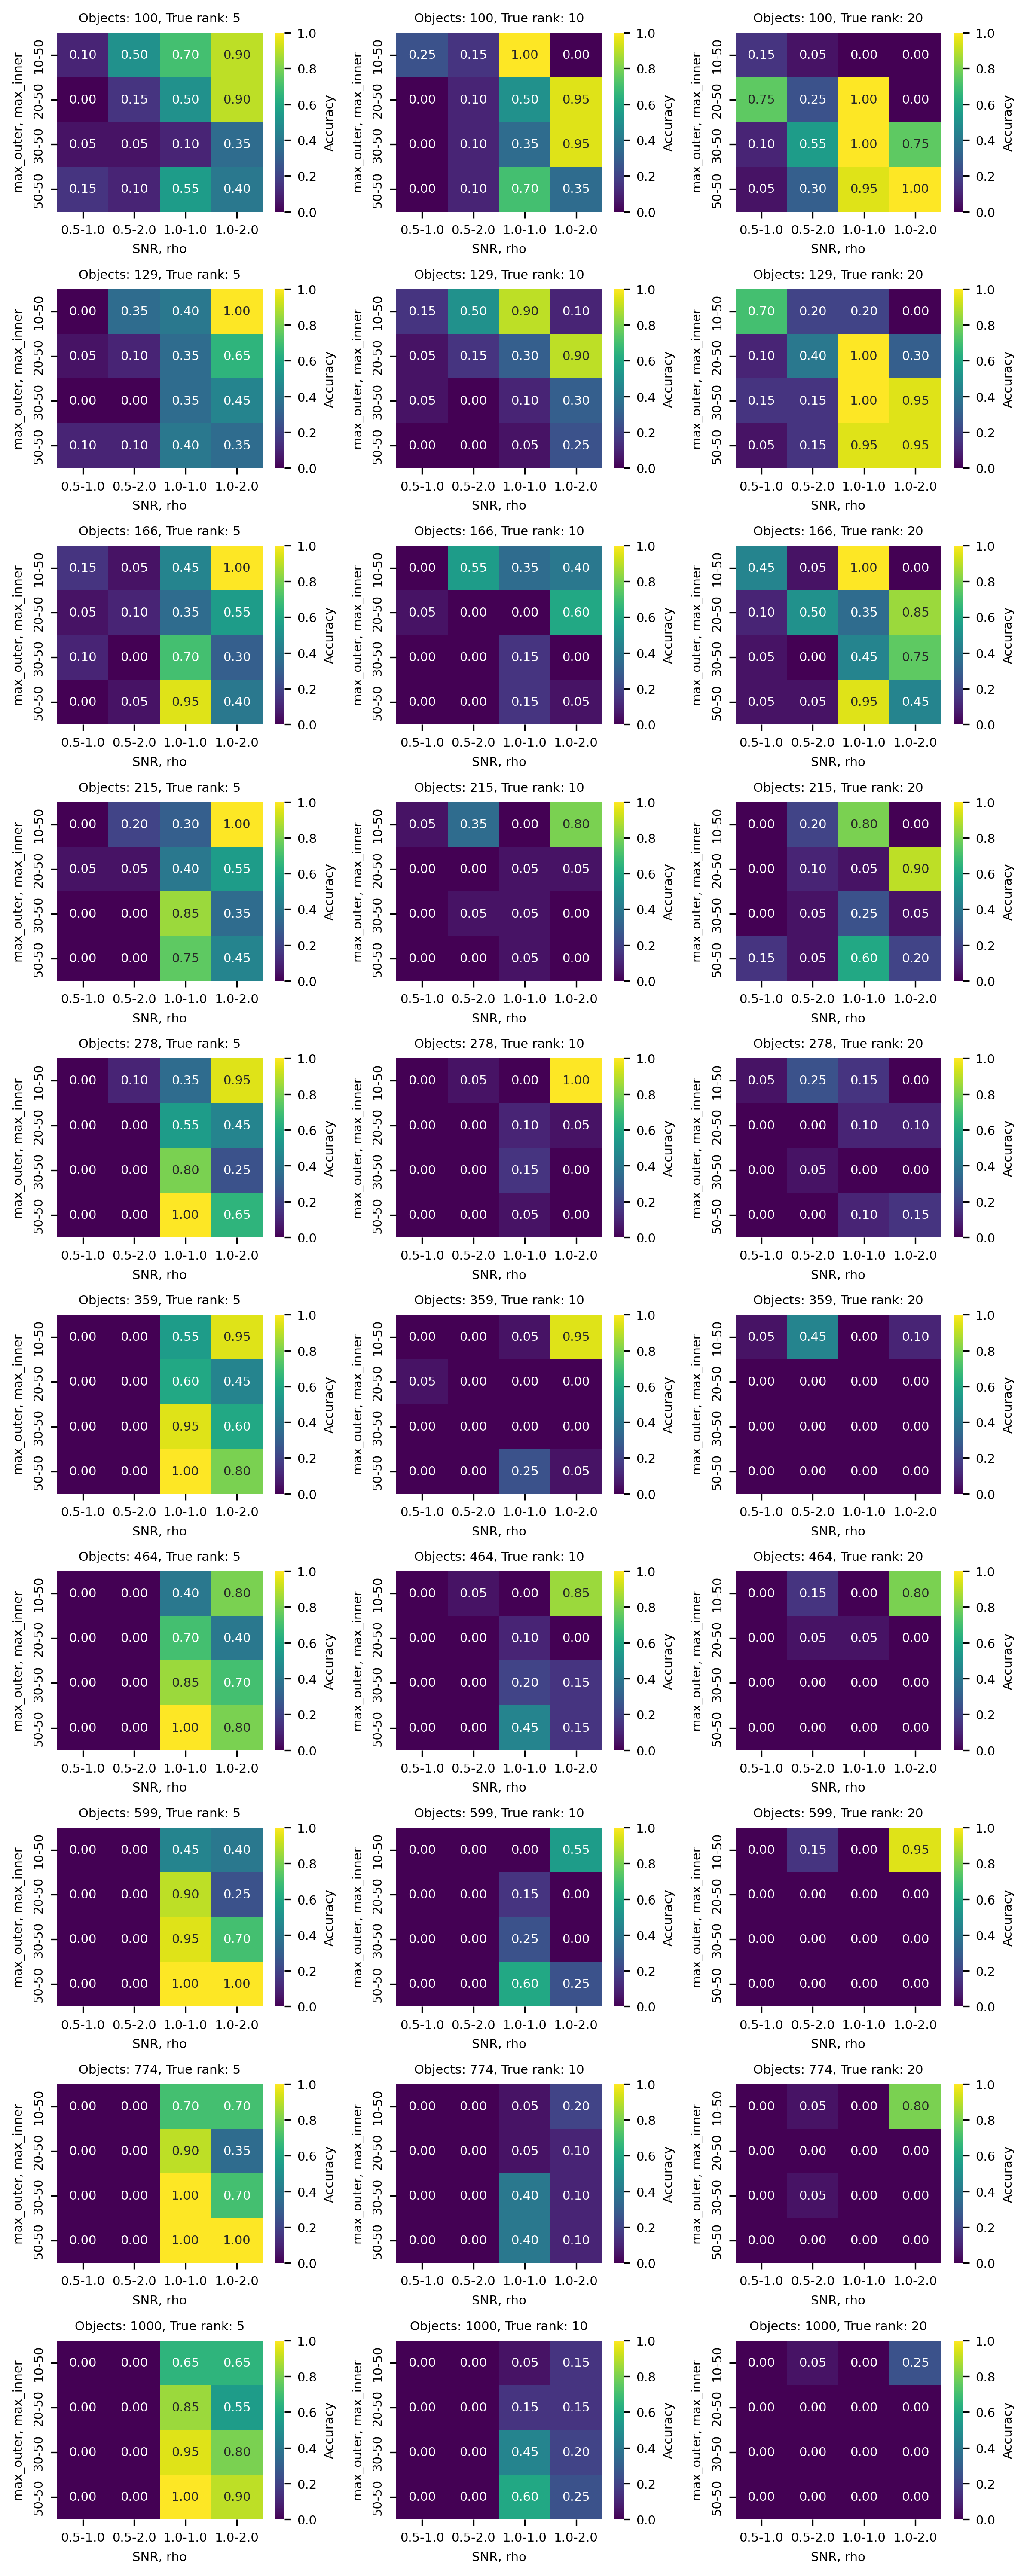

In [55]:
plt.rcParams.update({"font.size": 7})

unique_objects = sorted(df_simulation["n_objects"].unique())
fig, axes = plt.subplots(
    len(unique_objects), 3, figsize=(8, 2 * len(unique_objects)), dpi=300
)

if len(unique_objects) == 1:
    axes = axes.reshape(1, -1)

for obj_idx, n_objects in enumerate(unique_objects):
    for i, true_rank in enumerate([5, 10, 20]):
        subset = df_simulation[
            (df_simulation["true_rank"] == true_rank)
            & (df_simulation["n_objects"] == n_objects)
        ]

        if len(subset) > 0:
            pivot_data = subset.pivot_table(
                values="rank_correct",
                index=["max_outer", "max_inner"],
                columns=["snr", "rho"],
                aggfunc="mean",
            )

            sns.heatmap(
                pivot_data,
                ax=axes[obj_idx, i],
                cmap="viridis",
                annot=True,
                fmt=".2f",
                cbar_kws={"label": "Accuracy"},
                vmin=0,
                vmax=1,
            )
            axes[obj_idx, i].set_title(
                f"Objects: {n_objects}, True rank: {true_rank}", fontsize=7
            )
            axes[obj_idx, i].set_xlabel("SNR, rho", fontsize=7)
            axes[obj_idx, i].set_ylabel("max_outer, max_inner", fontsize=7)
        else:
            axes[obj_idx, i].text(
                0.5,
                0.5,
                "No data",
                ha="center",
                va="center",
                transform=axes[obj_idx, i].transAxes,
            )
            axes[obj_idx, i].set_title(
                f"Objects: {n_objects}, True rank: {true_rank}", fontsize=7
            )

plt.tight_layout()
plt.show()


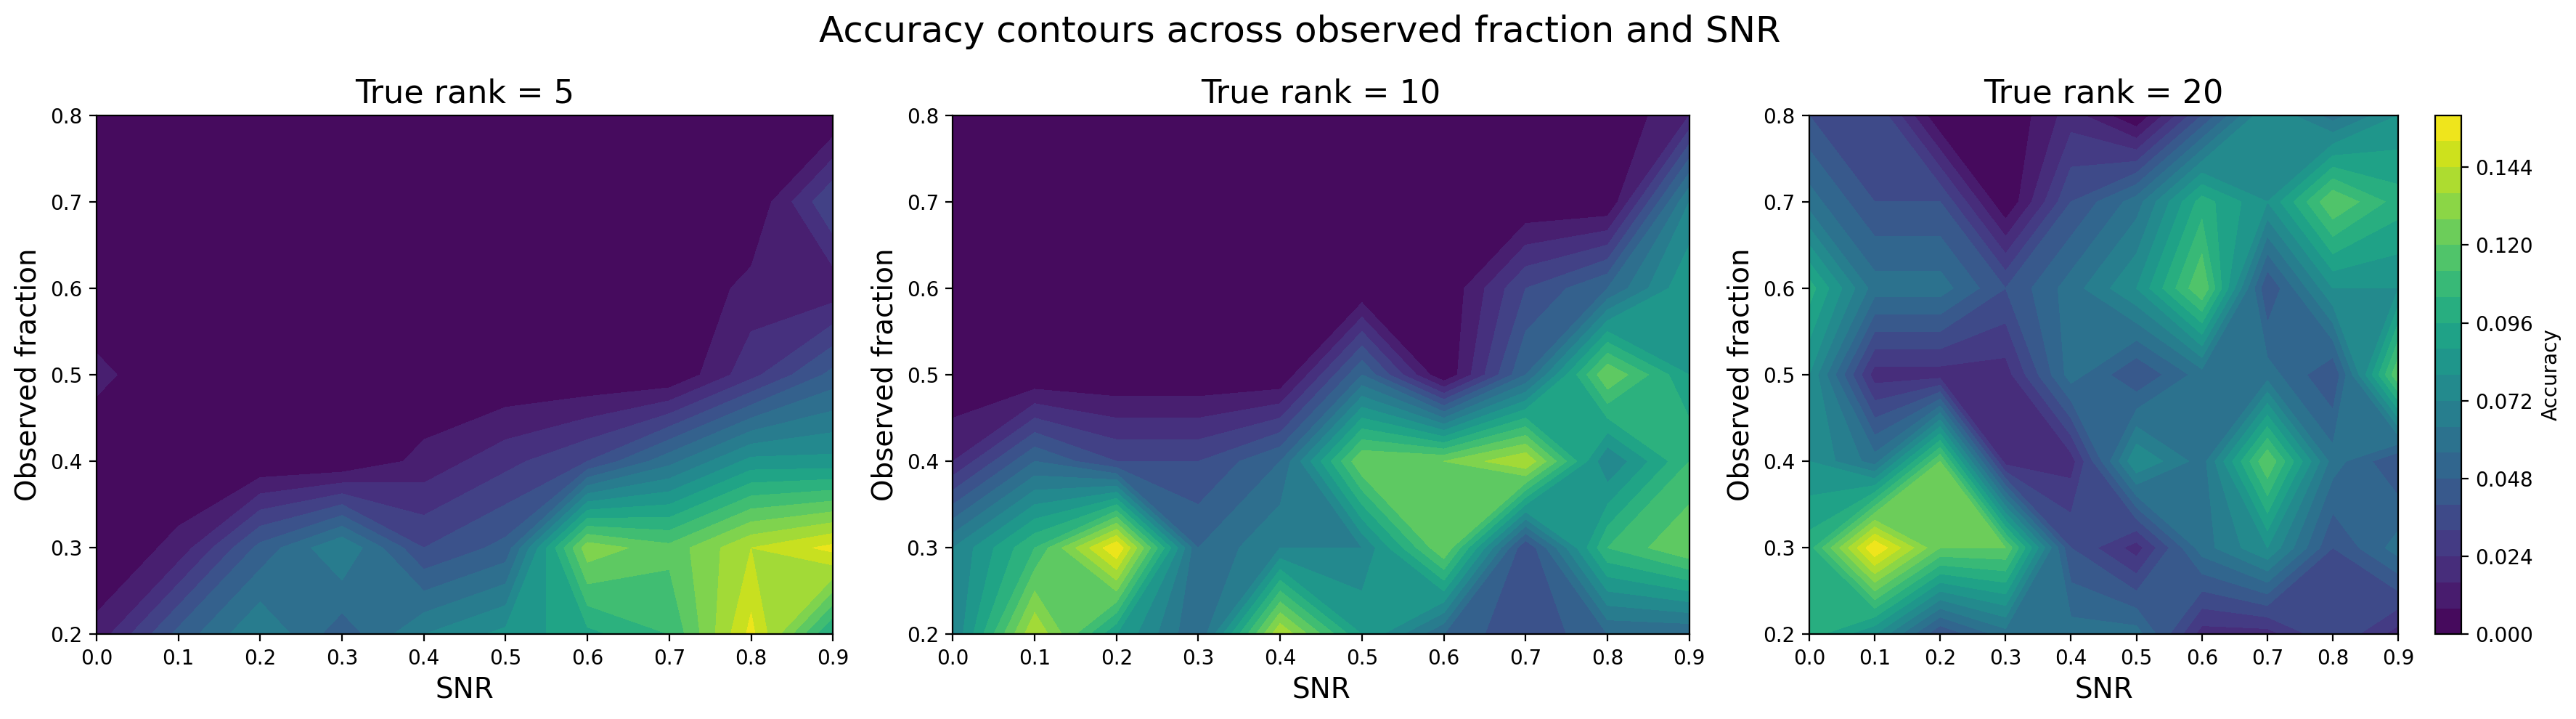

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=200)

for i, true_rank in enumerate([5, 10, 20]):
    subset = accuracy_df[accuracy_df["true_rank"] == true_rank]

    pivot_data = (
        subset.groupby(["observed_fraction", "snr"])["accuracy"].mean().unstack()
    )

    im = axes[i].contourf(
        pivot_data.columns,
        pivot_data.index,
        pivot_data.values,
        levels=20,
        cmap="viridis",
    )
    axes[i].set_xlabel("SNR", fontsize=14)
    axes[i].set_ylabel("Observed fraction", fontsize=14)
    axes[i].set_title(f"True rank = {true_rank}", fontsize=16)

    if i == 2:
        plt.colorbar(im, ax=axes[i], label="Accuracy")

plt.suptitle("Accuracy contours across observed fraction and SNR", fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.read_csv("../results/rank_detection_results.csv")

best_ranks = df.groupby(
    ["n_objects", "observed_fraction", "true_rank", "snr", "trial_id"]
)["mse"].idxmin()
best_ranks_df = df.loc[best_ranks]
best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]

accuracy_df = (
    best_ranks_df.groupby(["n_objects", "observed_fraction", "true_rank", "snr"])[
        "correct_rank"
    ]
    .mean()
    .reset_index()
)


/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 3000x800 with 0 Axes>

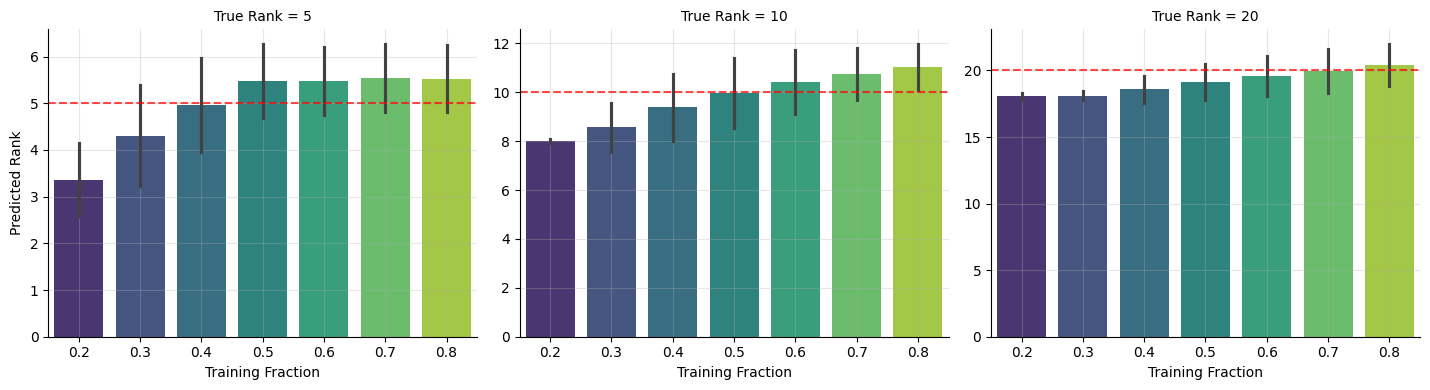

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../results/rank_detection_results.csv")

predicted_ranks = df.loc[
    df.groupby(["n_objects", "train_ratio", "trial_id", "true_rank"])["mse"].idxmin()
][["n_objects", "train_ratio", "trial_id", "true_rank", "rank", "mse"]].copy()

predicted_ranks = predicted_ranks.rename(columns={"rank": "predicted_rank"})

plt.figure(figsize=(15, 4), dpi=200)
g = sns.FacetGrid(
    predicted_ranks,
    col="true_rank",
    height=4,
    aspect=1.2,
    sharey=False,
)
g.map_dataframe(
    sns.barplot,
    x="train_ratio",
    y="predicted_rank",
    errorbar="sd",
    palette="viridis",
)
g.set_axis_labels("Training Fraction", "Predicted Rank")
g.set_titles("True Rank = {col_name}")

for ax, true_rank in zip(g.axes.flat, sorted(predicted_ranks["true_rank"].unique())):
    ax.axhline(y=true_rank, color="red", linestyle="--", alpha=0.7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


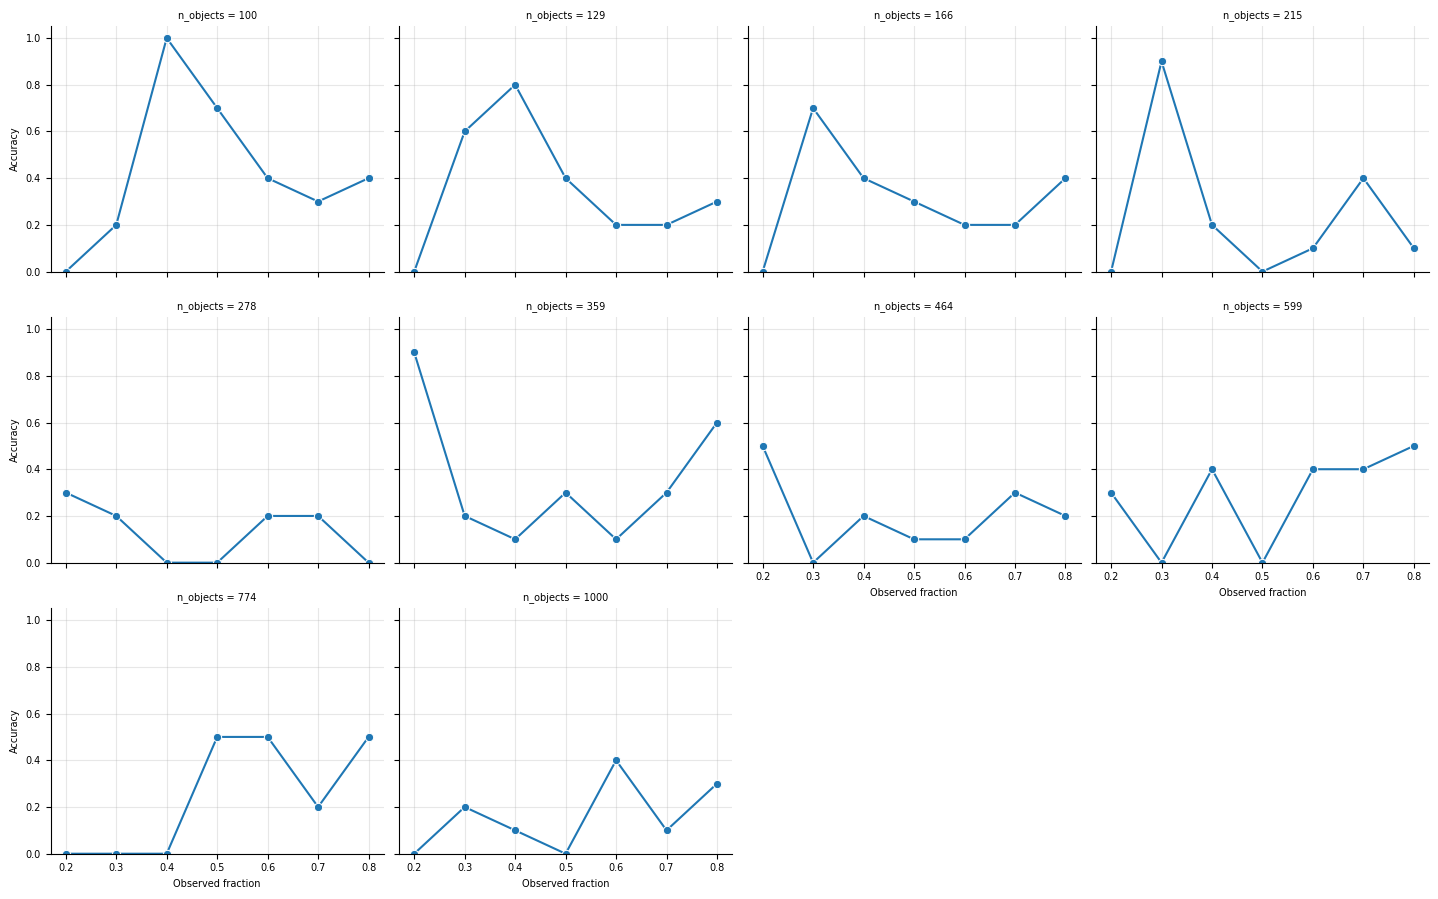

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load results
# df = pd.read_csv("../results/cross_validation/rank_detection.csv")
df = df_similarity[df_similarity["snr"] == 1.0]

# For each (n_objects, train_ratio, trial_id), find the rank with minimum mse
best_ranks = df.loc[
    df.groupby(["n_objects", "observed_fraction", "trial_id"])["mse"].idxmin()
]

# Add a column indicating whether the selected rank matches the true rank
best_ranks["correct_rank"] = (best_ranks["rank"] == best_ranks["true_rank"]).astype(int)

# Compute accuracy (fraction of correct rank selections) for each (n_objects, train_ratio)
accuracy = (
    best_ranks.groupby(["n_objects", "observed_fraction"])["correct_rank"]
    .mean()
    .reset_index()
    .rename(columns={"correct_rank": "accuracy"})
)

# Plot accuracy as a function of train_ratio, faceted by n_objects
g = sns.FacetGrid(
    accuracy,
    col="n_objects",
    col_wrap=4,
    sharey=True,
    height=3,
    aspect=1.2,
)
g.map_dataframe(sns.lineplot, x="observed_fraction", y="accuracy", marker="o")
g.set_axis_labels("Observed fraction", "Accuracy")
g.set_titles("n_objects = {col_name}")
for ax in g.axes.flatten():
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Checking the rank selection for eg DNNs etc

In [102]:
# peterson = load_dataset("peterson-various")
# rsm = peterson.rsm
# mur92 = load_dataset("mur92")
# rsm = mur92.group_rsm

x = load_dataset("dnn", behavior=True)
x = x.data["vgg16_bn.IMAGENET1K_V1.architecture"]
rsm = compute_similarity(x, x, "cosine")

import numpy as np
from cross_validation import cross_val_score

df = cross_val_score(
    rsm,
    observed_fraction=0.8,
    n_repeats=20,
    param_grid={"rank": np.arange(5, 95, 10), "max_outer": [50], "max_inner": [100]},
)


Running 180 jobs (9 params x 20 CV splits)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.


KeyboardInterrupt: 

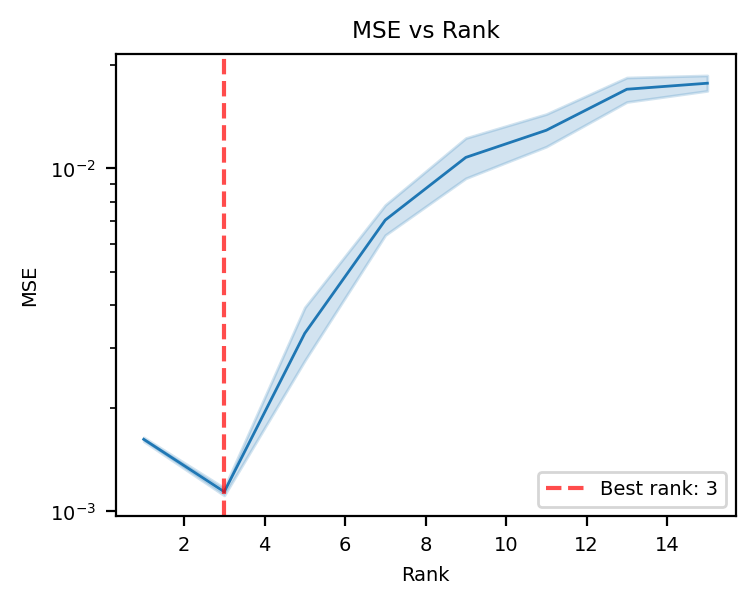

In [99]:
cv = df.cv_results_
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.lineplot(x="rank", y="score", data=cv, ax=ax, linewidth=1)
ax.set_yscale("log")

ax.set_xlabel("Rank")
ax.set_ylabel("MSE")
ax.set_title("MSE vs Rank")

best_rank = df.best_params_["rank"]
ax.axvline(
    x=best_rank, color="red", linestyle="--", alpha=0.7, label=f"Best rank: {best_rank}"
)
ax.legend()
plt.show()


In [82]:
from utils.helpers import compute_subsampling_fraction_symmetric

frac = compute_subsampling_fraction_symmetric(rsm, constant=0.01)


Effective rank: 45.006611759421894
Required samples: 1237.8660185526903
Degrees of freedom: 7260
Fraction of entries to sample: 0.17050496123315292


{'max_inner': np.int64(20), 'max_outer': np.int64(10), 'rank': np.int64(10)}


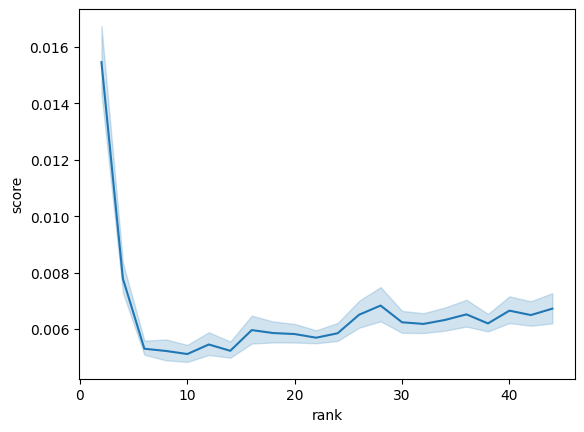

In [41]:
import matplotlib.pyplot as plt


cv = df.cv_results_

# print the best rank
print(df.best_params_)

sns.lineplot(data=cv, x="rank", y="score")
plt.show()
